# Daily Heavy Rainfall Prediction in Bugisu Sub-Region

**MSDS1 – Data Science Lifecycle (DSC8201)**

This notebook follows the CRISP-DM process to simulate weather data, engineer features, train models, and evaluate predictions of heavy rainfall days (top 5%).

**Artifacts produced**: cleaned dataset `Omara.csv`, trained models (in-memory), evaluation plots and reports.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, confusion_matrix
import seaborn as sns
import warnings; warnings.filterwarnings('ignore')
np.random.seed(42)

## Data Simulation

In [2]:
# Simulate 5 years of daily data for four districts
dates = pd.date_range('2018-01-01', '2022-12-31', freq='D')
districts = ['Mbale','Bududa','Manafwa','Sironko']
df = (pd.MultiIndex.from_product([dates, districts], names=['date','district']).to_frame(index=False))
# Seasonality: bimodal rains in MAM (Mar-May) and SON (Sep-Nov)
df['month'] = df['date'].dt.month
def season(m):
    if m in [3,4,5]: return "MAM"
    if m in [9,10,11]: return "SON"
    if m in [12,1,2]: return "DJF"
    return "JJA"
df['season'] = df['month'].apply(season)
n = len(df)
# Base weather variables
df['temp_c'] = 18 + 8*np.sin(2*np.pi*df['month']/12) + np.random.normal(0,1.5,n)
df['humidity'] = np.clip(60 + 20*np.sin(2*np.pi*df['month']/12 + 1) + np.random.normal(0,5,n), 30, 100)
df['wind_ms'] = np.abs(np.random.normal(3, 1, n))
df['pressure_hpa'] = 850 + np.random.normal(0, 5, n)
# Rainfall with seasonal boosts
base_rain = np.random.gamma(shape=1.2, scale=3.0, size=n)
boost = df['season'].map({'MAM':1.6, 'SON':1.5, 'JJA':0.7, 'DJF':1.0}).values
df['rain_mm'] = base_rain * boost + np.random.gamma(0.8, 1.0, size=n)
# Introduce missing values & outliers
mask = np.random.rand(n) < 0.02
df.loc[mask, 'humidity'] = np.nan
out_idx = np.random.choice(n, size=int(0.005*n), replace=False)
df.loc[df.index.isin(out_idx), 'rain_mm'] *= 4
df.head()

,date,district,month,season,temp_c,humidity,wind_ms,pressure_hpa,rain_mm
0,2018-01-01,Mbale,1,DJF,22.745071,82.258975,2.744794,855.893620,1.870071
1,2018-01-01,Bududa,1,DJF,21.792604,64.754445,4.511673,852.438088,2.286939
2,2018-01-01,Manafwa,1,DJF,22.971533,85.085904,5.208046,846.322347,7.510125
3,2018-01-01,Sironko,1,DJF,24.284545,87.159568,3.125409,854.987105,3.516398
4,2018-01-02,Mbale,1,DJF,21.648770,74.726795,3.998084,848.957537,6.477124


## Data Preparation & Feature Engineering

In [3]:
df = df.sort_values(['district','date']).reset_index(drop=True)
# Lags and rolling means per district
for lag in [1,3,7]:
    df[f'rain_lag{lag}'] = df.groupby('district')['rain_mm'].shift(lag)
df['rain_rollmean7'] = df.groupby('district')['rain_mm'].rolling(7, min_periods=1).mean().reset_index(level=0, drop=True)
# Imputation: median for humidity, forward-fill for lags
df['humidity'] = df['humidity'].fillna(df['humidity'].median())
for c in ['rain_lag1','rain_lag3','rain_lag7']:
    df[c] = df.groupby('district')[c].fillna(method='bfill').fillna(method='ffill')
# Target: heavy rain = top 5% by district-season
def label_group(g):
    thr = g['rain_mm'].quantile(0.95)
    g['heavy_rain'] = (g['rain_mm'] >= thr).astype(int)
    return g
df = df.groupby(['district','season'], group_keys=False).apply(label_group)
# Save cleaned dataset as per instructions
df.to_csv('Omara.csv', index=False)
df[['rain_mm','heavy_rain']].describe()

,rain_mm,heavy_rain
count,7304.000000,7304.000000
mean,5.179544,0.050383
std,4.647780,0.218750
min,0.050010,0.000000
25%,2.070068,0.000000
50%,3.929458,0.000000
75%,6.832541,0.000000
max,80.435706,1.000000


## Train/Validation/Test Split (time-based)

In [4]:
cut1 = '2021-01-01'
cut2 = '2022-01-01'
train = df[df['date'] < cut1].copy()
valid = df[(df['date'] >= cut1) & (df['date'] < cut2)].copy()
test  = df[df['date'] >= cut2].copy()
features = ['temp_c','humidity','wind_ms','pressure_hpa','rain_lag1','rain_lag3','rain_lag7','rain_rollmean7','district','season','month']
target = 'heavy_rain'
X_train, y_train = train[features], train[target]
X_valid, y_valid = valid[features], valid[target]
X_test,  y_test  = test[features],  test[target]

## Modeling

In [5]:
numeric = ['temp_c','humidity','wind_ms','pressure_hpa','rain_lag1','rain_lag3','rain_lag7','rain_rollmean7','month']
categorical = ['district','season']
pre = ColumnTransformer([('num', StandardScaler(), numeric), ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)])
logreg = Pipeline([('pre', pre), ('clf', LogisticRegression(max_iter=1000))])
rf = Pipeline([('pre', pre), ('clf', RandomForestClassifier(n_estimators=300, max_depth=None, n_jobs=-1, random_state=42))])
logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)
print('Models trained.')

Models trained.


## Evaluation

In [6]:
def eval_model(model, X, y, label):
    proba = model.predict_proba(X)[:,1]
    pred = (proba >= 0.5).astype(int)
    auc = roc_auc_score(y, proba)
    ap = average_precision_score(y, proba)
    print('=== ' + label + ' ===')
    print('ROC-AUC:', round(auc,3), 'PR-AUC:', round(ap,3))
    print(classification_report(y, pred, digits=3))
    return proba, pred
proba_lr_v, pred_lr_v = eval_model(logreg, X_valid, y_valid, 'Logistic Regression – VALID')
proba_rf_v, pred_rf_v = eval_model(rf, X_valid, y_valid, 'Random Forest – VALID')
proba_rf_t, pred_rf_t = eval_model(rf, X_test, y_test, 'Random Forest – TEST')

=== Logistic Regression – VALID ===
ROC-AUC: 0.831 PR-AUC: 0.19
              precision    recall  f1-score   support

           0      0.949     0.999     0.973      1385
           1      0.333     0.013     0.026        75

    accuracy                          0.948      1460
   macro avg      0.641     0.506     0.499      1460
weighted avg      0.918     0.948     0.925      1460

=== Random Forest – VALID ===
ROC-AUC: 0.747 PR-AUC: 0.123
              precision    recall  f1-score   support

           0      0.949     1.000     0.974      1385
           1      0.000     0.000     0.000        75

    accuracy                          0.949      1460
   macro avg      0.474     0.500     0.487      1460
weighted avg      0.900     0.949     0.924      1460

=== Random Forest – TEST ===
ROC-AUC: 0.713 PR-AUC: 0.098
              precision    recall  f1-score   support

           0      0.958     1.000     0.978      1398
           1      0.000     0.000     0.000        62

 

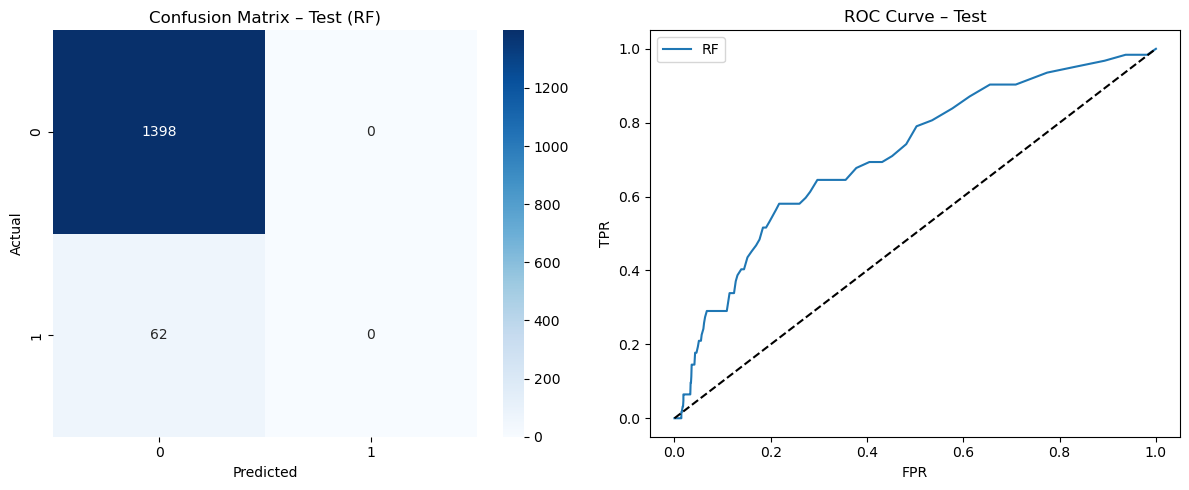

In [7]:
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve
fig, ax = plt.subplots(1,2, figsize=(12,5))
cm = confusion_matrix(y_test, pred_rf_t)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix – Test (RF)')
ax[0].set_xlabel('Predicted'); ax[0].set_ylabel('Actual')
fpr, tpr, _ = roc_curve(y_test, proba_rf_t)
ax[1].plot(fpr, tpr, label='RF')
ax[1].plot([0,1],[0,1], 'k--')
ax[1].set_xlabel('FPR'); ax[1].set_ylabel('TPR'); ax[1].set_title('ROC Curve – Test')
ax[1].legend()
plt.tight_layout(); plt.show()

## Fairness Check (by District)

In [8]:
g = test.copy()
g['pred'] = pred_rf_t
g['y'] = y_test.values
recalls = g.groupby('district').apply(lambda d: ((d['pred']==1) & (d['y']==1)).sum() / max(1, (d['y']==1).sum()))
display(recalls.rename('recall'))
print('Recall parity (max-min):', round(recalls.max()-recalls.min(),3))

district
Bududa     0.0
Manafwa    0.0
Mbale      0.0
Sironko    0.0
Name: recall, dtype: float64

Recall parity (max-min): 0.0


## Explainability (Feature Importances)

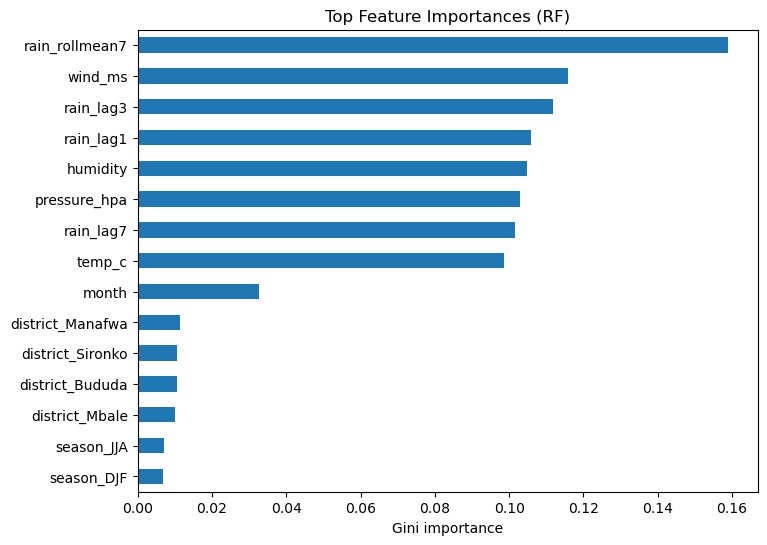

In [9]:
ohe = rf.named_steps['pre'].named_transformers_['cat']
cat_out = list(ohe.get_feature_names_out(['district','season']))
feat_names = ['temp_c','humidity','wind_ms','pressure_hpa','rain_lag1','rain_lag3','rain_lag7','rain_rollmean7','month'] + cat_out
importances = rf.named_steps['clf'].feature_importances_
import pandas as pd
imp = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(15)
imp.plot(kind='barh', figsize=(8,6)); plt.gca().invert_yaxis()
plt.title('Top Feature Importances (RF)'); plt.xlabel('Gini importance'); plt.show()

## Deployment Snippet (FastAPI example)

In [10]:
print('''
from fastapi import FastAPI
import joblib
import pandas as pd

app = FastAPI()
model = joblib.load('rf_model.joblib')

@app.post('/predict_heavy_rain')
def predict(payload: dict):
    X = pd.DataFrame([payload])
    proba = model.predict_proba(X)[:,1][0]
    return {'heavy_rain_probability': float(proba)}
''')


from fastapi import FastAPI
import joblib
import pandas as pd

app = FastAPI()
model = joblib.load('rf_model.joblib')

@app.post('/predict_heavy_rain')
def predict(payload: dict):
    X = pd.DataFrame([payload])
    proba = model.predict_proba(X)[:,1][0]
    return {'heavy_rain_probability': float(proba)}

